<a href="https://colab.research.google.com/github/AilingLiu/property_price_prediction/blob/master/housing_price_predict.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This project follows the tutorial from O'Reilly latest book of **Hands-on Machine Learning with sckikit-learn, keras and tensorflow** chapter two. 

# set up

In [0]:
import sys
assert sys.version_info >= (3, 5)

import sklearn
assert sklearn.__version__ >= '0.2'

import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline

# to plot properly
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

In [0]:
# where to save figures
PROJECT_ROOT_DIR = '.'
CHAPTER_ID = 'HOUSING'
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, CHAPTER_ID, 'IMAGES')
if not os.path.isdir(IMAGES_PATH):
  os.makedirs(IMAGES_PATH)

# saving figures helper
def save_fig(figure_name, path=IMAGES_PATH, dpi=300, tight_layout=True, format='png'):
  figure_path=os.path.join(path, figure_name+'.'+format)
  if tight_layout:
    plt.tight_layout()
  plt.savefig(figure_path, dpi=dpi, format=format)

# where to save data
DATA_PATH = os.path.join(PROJECT_ROOT_DIR, CHAPTER_ID, 'DATASETS')

# where to save model pickle
MODEL_PATH = os.path.join(PROJECT_ROOT_DIR, CHAPTER_ID, 'MODELS')
if not os.path.isdir(MODEL_PATH):
  os.makedirs(MODEL_PATH)

import joblib
def save_model(model_obj, model_name, path=MODEL_PATH):
  model_path = os.path.join(path, model_name+'.pkl')
  joblib.dump(model_obj, model_path)

# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

# get data

In [0]:
import urllib

url = 'https://raw.githubusercontent.com/ageron/handson-ml2/master/datasets/housing/housing.csv'

def fetch_data(url=url, path=DATA_PATH):
  if not os.path.isdir(path):
    os.makedirs(path)
  file_path = os.path.join(path, 'housing.csv')
  urllib.request.urlretrieve(url, file_path)
  print(f'Your file is downloaded in: \n{file_path}')

In [4]:
fetch_data()

Your file is downloaded in: 
./HOUSING/DATASETS/housing.csv


In [5]:
!head -n 3 'HOUSING/DATASETS/housing.csv'

longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY


In [0]:
def load_data(path=DATA_PATH):
  csv_path=os.path.join(path, 'housing.csv')
  return pd.read_csv(csv_path)

In [6]:
housing = load_data()
housing.head(3)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY


# A quick look of data structure

In [8]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
longitude             20640 non-null float64
latitude              20640 non-null float64
housing_median_age    20640 non-null float64
total_rooms           20640 non-null float64
total_bedrooms        20433 non-null float64
population            20640 non-null float64
households            20640 non-null float64
median_income         20640 non-null float64
median_house_value    20640 non-null float64
ocean_proximity       20640 non-null object
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


This dataset contains 20640 rows, not a large dataset. It has 10 attributes. One of the attributes `total_bedrooms` has a small amount of missing values. 

One categorical attribute, and the rest are numerical attributes.

In [9]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


We can see the last few attributes starting from `total_rooms` to `median_house_value` are highly skewed, since 75% threshold value is way from maximum values. We can check their distribution status by histogram.

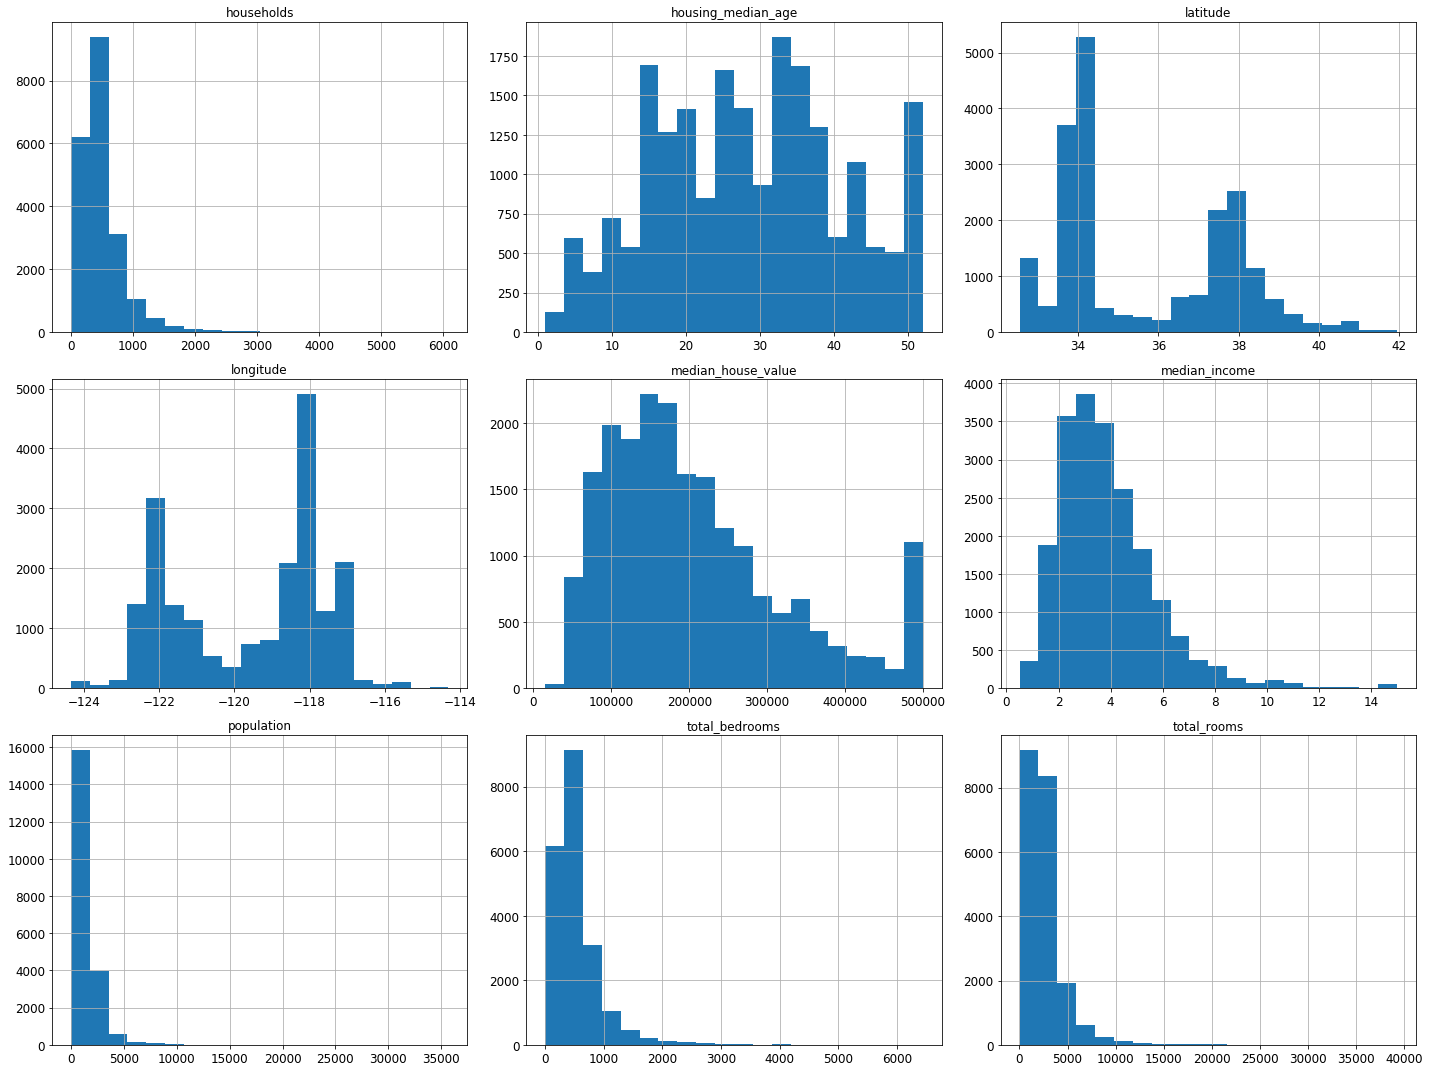

In [10]:
housing.hist(bins=20, figsize=(20, 15))
save_fig('housing_numerical_features_histogram_plot')

notes:

1. what's the unit of `median_income`? Any cap?
2. `median_house_value` seems capped?
3. Attributes have different scale
4. Most attributes are tail heavy
5. `longtitude` and `latitude` are bi-modal, which means there are two to four regions dominating the datasets.


# create test set

In [0]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

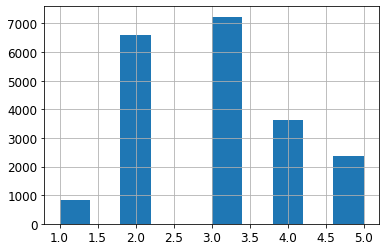

In [9]:
# suppose median_income is a strong predictor, we can split the train and test set with proportional strata
housing['income_cat'] = pd.cut(housing['median_income'], bins=[0, 1.5, 3, 4.5, 6, np.inf], labels=[1, 2, 3, 4, 5])
housing['income_cat'].hist()

In [10]:
# then we can split the data according the new categories
from sklearn.model_selection import StratifiedShuffleSplit
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

for train_index, test_index in split.split(housing, housing['income_cat']):
  strat_train_set = housing.iloc[train_index]
  strat_test_set = housing.iloc[test_index]

strat_test_set['income_cat'].value_counts(normalize=True)

3    0.350533
2    0.318798
4    0.176357
5    0.114583
1    0.039729
Name: income_cat, dtype: float64

In [14]:
def income_cat_proportions(data):
  return data['income_cat'].value_counts(normalize=True)

train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

compare_props = pd.DataFrame({'Overall': income_cat_proportions(housing),
              'Random': income_cat_proportions(test_set),
              'Stratified': income_cat_proportions(strat_test_set)}).sort_index()
compare_props['Rand.%error'] = 100*compare_props['Random']/compare_props['Overall'] - 100
compare_props['Strat.%error'] = 100*compare_props['Stratified']/compare_props['Overall'] - 100
display(compare_props)

,Overall,Random,Stratified,Rand.%error,Strat.%error
1,0.039826,0.040213,0.039729,0.973236,-0.243309
2,0.318847,0.324370,0.318798,1.732260,-0.015195
3,0.350581,0.358527,0.350533,2.266446,-0.013820
4,0.176308,0.167393,0.176357,-5.056334,0.027480
5,0.114438,0.109496,0.114583,-4.318374,0.127011


The test set generated from stratified sampling has almost identical proportions of income of full dataset, while the random sampling appears to be skewed.

In [11]:
# we need to drop the categories to make the data back to original shape
for data in strat_train_set, strat_test_set:
  data.drop('income_cat', axis=1, inplace=True)
  

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


# Visualisations Analysis

# visualizing geographical data

In [0]:
# make a copy on the training set
houses = strat_train_set.copy()

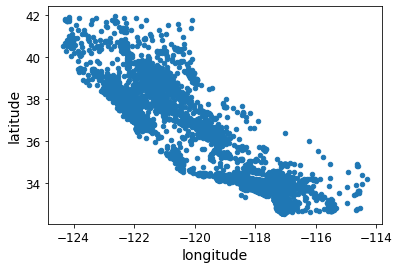

In [17]:
houses.plot(kind='scatter', x='longitude', y='latitude')

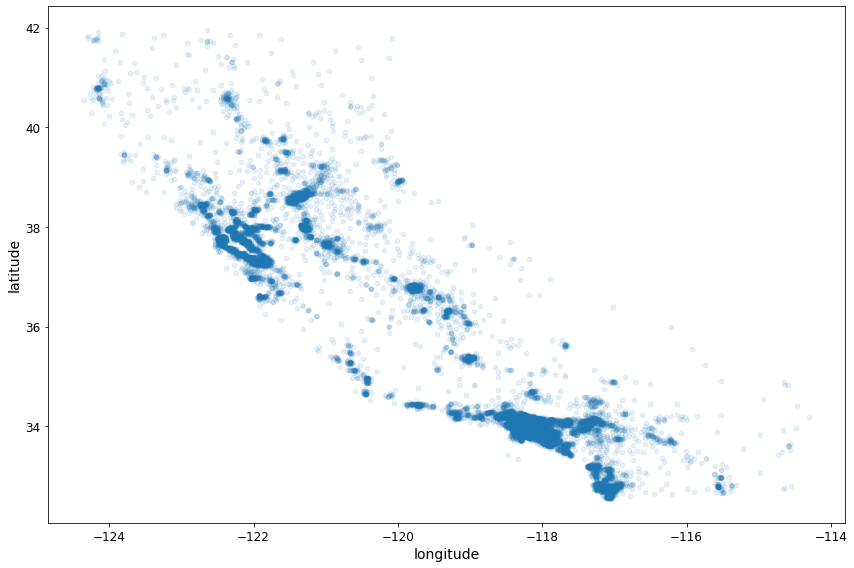

In [18]:
# too many overlapping points. let's use alpha to adjust the transparency
houses.plot(kind='scatter', alpha=0.1, x='longitude', y='latitude', figsize=(12, 8))
save_fig('scatterplot_longitude_latitude')

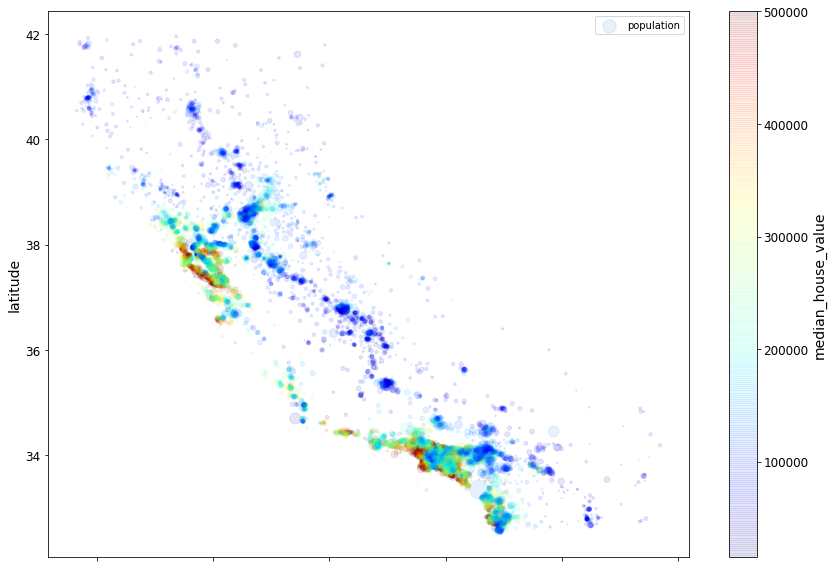

In [19]:
# let's add more parameters, radius of circle represent population, color heatmap low to high represent price
houses.plot(kind='scatter', alpha=0.1, x='longitude', y='latitude', s=houses['population']/100, label='population', c='median_house_value', cmap=plt.get_cmap('jet'), colorbar=True, figsize=(12, 8))
plt.legend()
save_fig('scatterplot_longitude_latitude')

Housing price are very much related to locations and pupulation density. We can use clustering algorithms to detect main clusters as new features. 

# looking for correlation

In [20]:
corr_matrix=houses.corr()
corr_matrix['median_house_value'].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.687160
total_rooms           0.135097
housing_median_age    0.114110
households            0.064506
total_bedrooms        0.047689
population           -0.026920
longitude            -0.047432
latitude             -0.142724
Name: median_house_value, dtype: float64

There is positive correlation between house value and income. The house value tends to go up when the median income increases. We can also see that the house vaue has a small negative relation with population density, and location.

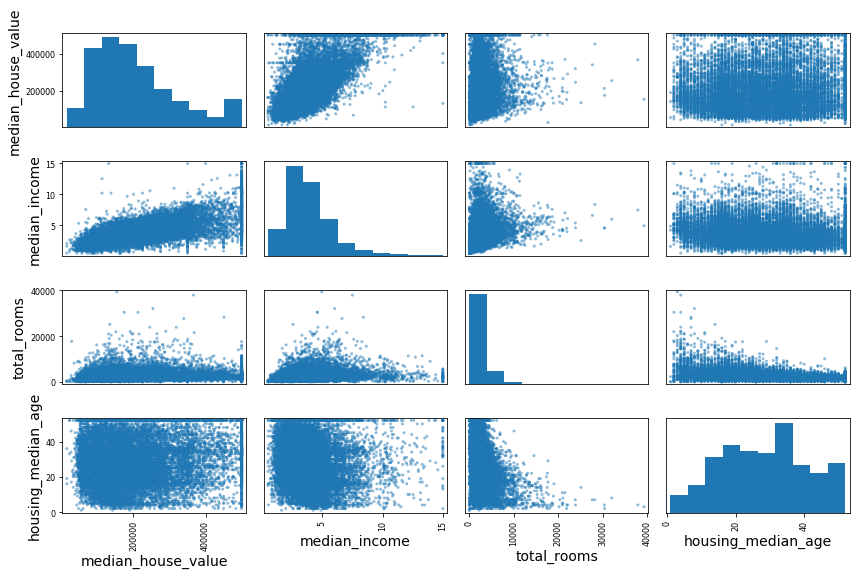

In [21]:
# we can also see the correlation using scatter plots
from pandas.plotting import scatter_matrix
attributes = ['median_house_value', 'median_income', 'total_rooms', 'housing_median_age']
scatter_matrix(houses[attributes], figsize=(12, 8))
save_fig('scatterplot_of_house_value_income_rooms_age')

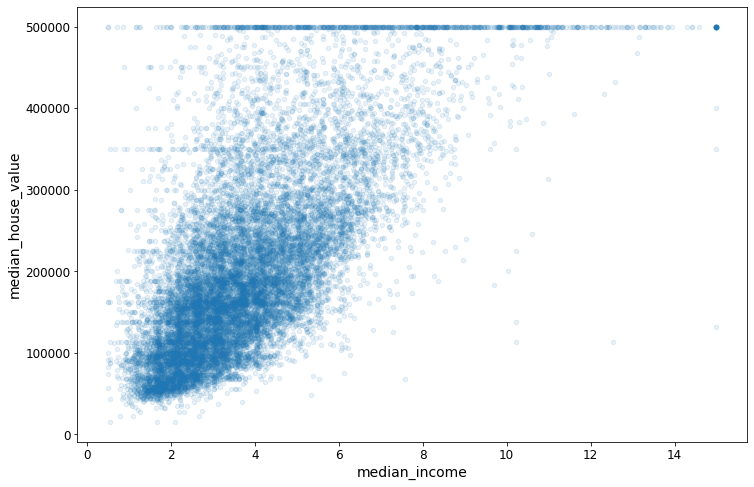

In [22]:
# the most promising attribute is house income. Let's look into that only.
houses.plot(kind='scatter', x='median_income', y='median_house_value', figsize=(12, 8), alpha=0.1)

There are visible horizontal lines in the plots, at 500k, 350k, and possiblely at 230k. Can consider to remove those districts to prevent algorithms learning those quirks.

# Experimenting with Attribute Combinations

In [23]:
houses['rooms_per_household'] = houses['total_rooms']/houses['households']
houses['bedroom_per_room'] = houses['total_bedrooms']/houses['total_rooms']
houses['population_per_household']=houses['population']/houses['households']
corr_matrix=houses.corr()
corr_matrix['median_house_value'].sort_values(ascending=False)

median_house_value          1.000000
median_income               0.687160
rooms_per_household         0.146285
total_rooms                 0.135097
housing_median_age          0.114110
households                  0.064506
total_bedrooms              0.047689
population_per_household   -0.021985
population                 -0.026920
longitude                  -0.047432
latitude                   -0.142724
bedroom_per_room           -0.259984
Name: median_house_value, dtype: float64

The bedroom_per_room ratio has negative effect on house value. The lower ratio sees more expensive price of house. The rooms_per_houseold ratio has a positive effect on house value.

# Prepare the data for machine learning algorithms

In this section, we need to write functions so we can reproduce the transformations easily and use for live system.

In [0]:
houses_features = strat_train_set.drop('median_house_value', axis=1)
houses_label = strat_train_set['median_house_value'].copy()

# Data Cleaning

In [13]:
# dealing with missing values, we can use median value to impute the missing values
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy='median')
# it only works on numerical features
houses_num = houses_features.drop('ocean_proximity', axis=1)
imputer.fit(houses_num)
imputer.statistics_

array([-118.51  ,   34.26  ,   29.    , 2119.5   ,  433.    , 1164.    ,
        408.    ,    3.5409])

In [14]:
houses_num.median().values

array([-118.51  ,   34.26  ,   29.    , 2119.5   ,  433.    , 1164.    ,
        408.    ,    3.5409])

In [0]:
X = imputer.fit(houses_num)
houses_tr = pd.DataFrame(X, columns=houses_num.columns, index=houses_num.index)

# Handling text and categorical attributes

In [16]:
houses_cat = houses_features[['ocean_proximity']]
houses_cat.head(10)

,ocean_proximity
17606,<1H OCEAN
18632,<1H OCEAN
14650,NEAR OCEAN
3230,INLAND
3555,<1H OCEAN
19480,INLAND
8879,<1H OCEAN
13685,INLAND
4937,<1H OCEAN
4861,<1H OCEAN


In [17]:
from sklearn.preprocessing import OrdinalEncoder

ordinal_encoder = OrdinalEncoder()
houses_cat_enc = ordinal_encoder.fit_transform(houses_cat)
houses_cat_enc[:10]

array([[0.],
       [0.],
       [4.],
       [1.],
       [0.],
       [1.],
       [0.],
       [1.],
       [0.],
       [0.]])

In [18]:
ordinal_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

However, there is no inner orders in the ocean proximity. We can use one hot encoding to fix this issue.

In [19]:
from sklearn.preprocessing import OneHotEncoder
onc_enc = OneHotEncoder()
houses_cat_ohc = onc_enc.fit_transform(houses_cat)
houses_cat_ohc


<16512x5 sparse matrix of type '<class 'numpy.float64'>'
	with 16512 stored elements in Compressed Sparse Row format>

In [20]:
# it's a sparse matrix, which means they only store the position where there's value 1. We can still visualize it by toarray() method

houses_cat_ohc.toarray()

array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       ...,
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0.]])

In [21]:
onc_enc.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

# Create Transformers

In [0]:
# we can use BaseEstimators for a free .fit_transform() method and TrasformMixIn for get_params() and set_params() method for hyperparameter tuning in later stage

from sklearn.base import BaseEstimator, TransformerMixin

class CombineAttributeAdder(BaseEstimator, TransformerMixin):
  def __init__(self, add_bedroom_per_household=True, rooms_ix=3, bedrooms_ix=4, population_ix=5, households_ix=6): # you can customize the index of each attribute
    self.add_bedroom_per_household = add_bedroom_per_household
    self.rooms_ix = rooms_ix
    self.bedrooms_ix = bedrooms_ix
    self.population_ix = population_ix
    self.households_ix = households_ix
  def fit(self, X, y=None):
    return self
  def transform(self, X, y=None):
    room_per_household = X[:, self.rooms_ix] / X[:, self.households_ix]
    population_per_household = X[:, self.population_ix] / X[:, self.households_ix]
    if self.add_bedroom_per_household:
      bedroom_per_household = X[:, self.bedrooms_ix] / X[:, self.households_ix]
      return np.c_[X, room_per_household, population_per_household, bedroom_per_household]
    else:
      return np.c_[X, room_per_household, population_per_household]

attr_adder = CombineAttributeAdder(add_bedroom_per_household=False)
housing_extra_attributes = attr_adder.transform(houses_features.values)    


# Transformation Pipeline

In [0]:
# add feature scaling to the pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

num_pipeline = Pipeline([
                         ('imputer', SimpleImputer(strategy='median')),
                         ('attr_adder', CombineAttributeAdder()),
                         ('std_scaler', StandardScaler())
])

housing_num_tr = num_pipeline.fit_transform(houses_num)

In [0]:
# a new feature in sklearn 2.0 is we can handle both categorical and numerical features together using ColumnTransformer
from sklearn.compose import ColumnTransformer

num_att = houses_num.columns.tolist()
cat_att = ['ocean_proximity']

full_pipeline = ColumnTransformer([
                                   ('num', num_pipeline, num_att),
                                   ('cat', OneHotEncoder(), cat_att)
])

housing_prepared = full_pipeline.fit_transform(houses_features)

In [25]:
housing_prepared

array([[-1.15604281,  0.77194962,  0.74333089, ...,  0.        ,
         0.        ,  0.        ],
       [-1.17602483,  0.6596948 , -1.1653172 , ...,  0.        ,
         0.        ,  0.        ],
       [ 1.18684903, -1.34218285,  0.18664186, ...,  0.        ,
         0.        ,  1.        ],
       ...,
       [ 1.58648943, -0.72478134, -1.56295222, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.78221312, -0.85106801,  0.18664186, ...,  0.        ,
         0.        ,  0.        ],
       [-1.43579109,  0.99645926,  1.85670895, ...,  0.        ,
         1.        ,  0.        ]])

In [26]:
housing_prepared.shape

(16512, 16)

# Select and train a model

## Training and Evaluating on the Traiing set

In [27]:
from sklearn.linear_model import LinearRegression


lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, houses_label)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [28]:
from sklearn.metrics import mean_squared_error

preds = lin_reg.predict(housing_prepared)
lin_mse = mean_squared_error(houses_label, preds)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

68911.49637588045

The result shows something but not to our satisfactory. This is underfitting problem. We can fix it by adding more features, try more complex models, or reduce the constrains on model. We will try a Decision Tree which is capable of capturing non-linear relations.

In [29]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor()
tree_reg.fit(housing_prepared, houses_label)
preds = tree_reg.predict(housing_prepared)
tree_mse = mean_squared_error(houses_label, preds)
tree_rmse = np.sqrt(tree_mse)
tree_rmse

0.0

In [30]:
tree_reg.feature_importances_

array([6.91705328e-02, 5.58595726e-02, 4.11188734e-02, 1.27165767e-02,
       1.24683871e-02, 1.17021658e-02, 1.04687909e-02, 4.71708228e-01,
       3.02713308e-02, 1.20657221e-01, 2.02028884e-02, 7.30082771e-04,
       1.40255313e-01, 0.00000000e+00, 4.10217660e-04, 2.25981963e-03])

In [0]:
save_model(tree_reg, 'tree_reg')

It's too good to be true. We are overfitting here. Let's do some cross validation using tree model to try again.

In [32]:
from sklearn.model_selection import cross_val_score

def display_score(scores):
  score_adj = np.sqrt(-scores)
  print('Scores: ', score_adj)
  print('\nMean Scores: ', score_adj.mean())
  print('\nStandard Deviation: ', score_adj.std())

tree_scores = cross_val_score(tree_reg, housing_prepared, houses_label, cv=10, scoring='neg_mean_squared_error')
display_score(tree_scores)

Scores:  [69774.58306783 68891.67491648 71727.25073356 72472.62202282
 69692.01638344 73274.81108039 72211.78112785 70444.2836392
 76126.54529724 69204.67065784]

Mean Scores:  71382.02389266496

Standard Deviation:  2129.607074577685


The decision tree has a score approximately 71.5k, generally $\pm$2.7k. 

In [33]:
lin_scores = cross_val_score(lin_reg, housing_prepared, houses_label, scoring='neg_mean_squared_error', cv=10)
display_score(lin_scores)

Scores:  [67474.11780426 67233.22466524 69301.86479972 74716.01783105
 68426.80214612 71609.98356263 65200.14338307 68687.78826919
 72262.43484426 68111.81213342]

Mean Scores:  69302.41894389637

Standard Deviation:  2653.4606994470405


The decision tree model overfits so much that it performs even worse than linear model. We can try the ensembel model Random Forest that runs many decision trees then average out their predictions. 

In [34]:
from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor()
forest_scores = cross_val_score(forest_reg, housing_prepared, houses_label, cv=10, scoring='neg_mean_squared_error')
display_score(forest_scores)

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The de

Scores:  [51293.80717685 50159.76938277 51981.68659086 55309.97982219
 50969.90690245 55383.3022985  51687.64062506 51171.88905059
 56261.29870317 53876.7705523 ]

Mean Scores:  52809.605110473836

Standard Deviation:  2079.878630669753


## Fine tune models

### Grid search

In [35]:
from sklearn.model_selection import GridSearchCV

param_grid = [
              {'n_estimators': [3, 10, 30], 'max_features': [4, 6, 8, 10]},
              {'bootstrap': [False], 'n_estimators': [10, 20, 30], 'max_features': [8, 10, 12]}
]

grid_search = GridSearchCV(forest_reg, param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(housing_prepared, houses_label)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=RandomForestRegressor(bootstrap=True, criterion='mse',
                                             max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators='warn', n_jobs=None,
                                             oob_score=False, random_state=None,
                                             verbose=0, warm_start=False),
             iid='warn', n_jobs=None,
             param_grid=[{'max_features': [4, 6, 8, 10],

In [36]:
grid_search.best_params_

{'bootstrap': False, 'max_features': 8, 'n_estimators': 30}

In [37]:
grid_search.best_estimator_

RandomForestRegressor(bootstrap=False, criterion='mse', max_depth=None,
                      max_features=8, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=30,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

In [0]:
cvres = grid_search.cv_results_

In [39]:
cvres.keys()

dict_keys(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'param_max_features', 'param_n_estimators', 'param_bootstrap', 'params', 'split0_test_score', 'split1_test_score', 'split2_test_score', 'split3_test_score', 'split4_test_score', 'mean_test_score', 'std_test_score', 'rank_test_score'])

In [40]:
for mean_scores, params in zip(cvres['mean_test_score'], cvres['params']):
  print(np.sqrt(-mean_scores), params)

59822.46769272614 {'max_features': 4, 'n_estimators': 3}
52401.675616959415 {'max_features': 4, 'n_estimators': 10}
50376.97411323837 {'max_features': 4, 'n_estimators': 30}
58738.04036007167 {'max_features': 6, 'n_estimators': 3}
52060.469529776856 {'max_features': 6, 'n_estimators': 10}
50042.33214221542 {'max_features': 6, 'n_estimators': 30}
58577.02412414415 {'max_features': 8, 'n_estimators': 3}
51732.12033408253 {'max_features': 8, 'n_estimators': 10}
49945.594543783394 {'max_features': 8, 'n_estimators': 30}
58374.53602561984 {'max_features': 10, 'n_estimators': 3}
51854.39277277071 {'max_features': 10, 'n_estimators': 10}
50131.90182782613 {'max_features': 10, 'n_estimators': 30}
51515.586731125375 {'bootstrap': False, 'max_features': 8, 'n_estimators': 10}
49998.29292928261 {'bootstrap': False, 'max_features': 8, 'n_estimators': 20}
49205.83047144118 {'bootstrap': False, 'max_features': 8, 'n_estimators': 30}
51664.2293403047 {'bootstrap': False, 'max_features': 10, 'n_estima

With the gridsearch best parameters, we can see the best score is 49540, which is much better than the score 53026 using default parameter.

### RandomSearch

In [0]:
# RadomSearch can enlarge our search parameters, as long as we run sufficient number of iterations.
from sklearn.model_selection import RandomizedSearchCV

param_grid = {'n_estimators': np.arange(10, 110, 10)}
rand_search = RandomizedSearchCV(forest_reg, param_grid, n_iter=50, scoring = 'neg_mean_squared_error', cv=5)
rand_search.fit(housing_prepared, houses_label) # takes few minutes to run on hosted runtime. suggest to run it locally if your gpu is better

In [0]:
rand_search.best_params_

# Analyze the best models and their errors

In [0]:
feature_imp = grid_search.best_estimator_.feature_importances_

In [45]:
houses_features.columns

Index(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income',
       'ocean_proximity'],
      dtype='object')

In [0]:
extra_att = ['room_per_household', 'population_per_household', 'bedroom_per_household']
num_att = houses_features.select_dtypes(include=np.number).columns.values.tolist()
onc_enc = full_pipeline.named_transformers_['cat'].categories_[0].tolist()
attributes = num_att + extra_att + onc_enc
assert(len(attributes) == len(feature_imp))

In [55]:
sorted(zip(feature_imp, attributes), reverse=True)

[(0.37826189241082525, 'median_income'),
 (0.1651536223966813, 'INLAND'),
 (0.1073903682796255, 'population_per_household'),
 (0.07853053129666224, 'longitude'),
 (0.0749615541731564, 'latitude'),
 (0.06324124159196905, 'room_per_household'),
 (0.04242394184491642, 'housing_median_age'),
 (0.02250521496804859, 'bedroom_per_household'),
 (0.01592597520981045, 'total_rooms'),
 (0.015378448897303956, 'population'),
 (0.013907483518205, 'households'),
 (0.013295352297274363, 'total_bedrooms'),
 (0.003810859340577453, '<1H OCEAN'),
 (0.0029453288555102547, 'NEAR OCEAN'),
 (0.0022230652756130872, 'NEAR BAY'),
 (4.511964382078572e-05, 'ISLAND')]

Only one category in `ocean_proximity` is useful. We can consider to drop others.

# Evaluate model on test set

In [0]:
final_model = grid_search.best_estimator_
X_test = strat_test_set.drop('median_house_value', axis=1)
y_test = strat_test_set['median_house_value'].copy()

X_test_prepared = full_pipeline.transform(X_test)
final_prediction = final_model.predict(X_test_prepared)

In [57]:
test_mse = mean_squared_error(y_test, final_prediction)
test_rmse = np.sqrt(test_mse)
test_rmse

46964.811253208296

In [59]:
# calculate a 95% confidence level for generalized error
from scipy import stats
confidence=0.95
squared_errors = (y_test - final_prediction)**2
np.sqrt(stats.t.interval(confidence, len(squared_errors)-1,
        loc=squared_errors.mean(), scale=stats.sem(squared_errors)))#

array([44937.41762423, 48908.2353941 ])

# Conclusion

median income is the number one predictor for house values. Although the final performance of the system is not not performing better than the expert's price estimates, which were often off by about 20%, but it may still be a good idea to launch it, especially if thi frees up soe time for the eperts so they can work on more interesting and productive tasks.